In [1]:
using Interpolations, Distributions, ForwardDiff, LinearAlgebra, FastGaussQuadrature, Plots
using Memoize, BenchmarkTools, Turing
using Random, Plots, Optim, DataFrames, MCMCChains, StatsPlots

abstract type Component end
abstract type Scatterer end
abstract type Model end

function flattenall(A)
    V = []
    for x in A
        if isa(x, AbstractArray)
            append!(V, flattenall(x))
        else
            push!(V, x)
        end
    end
    V
end

flattenall (generic function with 1 method)

In [2]:
# data stuff
using DelimitedFiles


mutable struct Data1D
    x::Vector
    y::Vector
    yerr::Union{Vector, Nothing}
    xerr::Union{Vector, Nothing}
    fname::Union{String, Nothing}
    Data1D(x::Vector, y::Vector) = new(x, y, nothing, nothing, nothing)
    Data1D(x::Vector, y::Vector, yerr::Vector) = new(x, y, yerr, nothing)
    Data1D(x::Vector, y::Vector, yerr::Vector, xerr::Vector) = new(x, y, yerr, xerr)
    Data1D(x::Vector, y::Vector; yerr::Vector, xerr::Vector) = new(x, y, yerr, xerr)
    function Data1D(x::Vector, y::Vector;
            yerr::Vector,
            xerr::Vector
        )
        new(x, y, yerr, xerr)
    end
    Data1D(filename::String) = read_data(filename)
end


function read_data(filename::String; delim=nothing)
    if isnothing(delim)
        arr = readdlm(filename)
    else
        arr = readdlm(filename, delim)
    end
    nrows, ncols = size(arr)

    if ncols == 2
        data = Data1D(arr[:, 1], arr[:, 2], nothing, nothing)
    elseif ncols == 3
        data = Data1D(arr[:, 1], arr[:, 2], arr[:, 3], nothing)
    elseif ncols == 4
        data = Data1D(arr[:, 1], arr[:, 2], arr[:, 3], arr[:, 4])
    end
    data.fname = filename
    return data
end


function refresh!(data::Data1D)
   data_updated = read_data(data.fname)
   data.x = data_updated.x
   data.y = data_updated.y
   data.yerr = data_updated.yerr
   data.xerr = data_updated.xerr
   return nothing
end


function Base.size(data::Data1D)
    return size(data.x)
end

function Base.length(data::Data1D)
    return length(data.x)
end

Plots.plot(data::Data1D) = plot(data.x, data.y, yaxis=:log)
Plots.plot!(data::Data1D) = plot!(data.x, data.y, yaxis=:log)

In [3]:
# parameters

mutable struct Parameter
    value::Real
    vary::Bool
    bounds::Distribution
    name::Union{String, Symbol}
    chain::Array
    stderr::Union{Nothing, Real}
    function Parameter(value::Real;
            vary::Bool=false,
            bounds::Distribution=Uniform(-Inf, Inf),
            name::Union{String, Symbol}=""
        )
        new(value, vary, bounds, name, [], nothing)
    end
end
# might need to get rid of this when it comes to autodifferentiation!
Base.Real(p::Parameter) = p.value


function build_parameter(p::Union{Parameter, Real}; name::Union{String, Symbol}="", vary=false)
    isa(p, Parameter) ? p : Parameter(p; name=name, vary=vary)
end

build_parameter (generic function with 1 method)

In [4]:
# const TINY = 1e-30
# const _FWHM = 2 * sqrt(2 * log(2.0))
# const PI4 = 4e-6 * pi
# const _INTLIMIT = 3.5

# function abeles(q, w)
#     nlayers = size(w, 1) - 2
#     npnts = length(q)

#     reflectivity = Vector{Any}(undef, (npnts))
#     oneC = Complex(1.0)

#     for j in eachindex(q)
#         qq2 = (q[j] * q[j] / 4.0) + 0.0im
#         kn = (q[j] / 2.) + 0.0im

#         # variables are local to if blocks
#         local MRtotal11, MRtotal12, MRtotal21, MRtotal22

#         for i = 1:nlayers+1
#             # wavevector in the layer
#             sld_next = ((w[i+1, 2] - w[1, 2]) + ((abs(w[i+1, 3]) + TINY))im) * pi * 4.0e-6
#             kn_next = sqrt(qq2 - sld_next)

#             # reflectance of the interface
#             rj = (kn - kn_next)/(kn + kn_next) * exp(kn * kn_next * (-2.0 * w[i+1, 4]^2))

#             if i == 1
#                 # characteristic matrix for first interface
#                 MRtotal11 = oneC
#                 MRtotal12 = rj
#                 MRtotal21 = rj
#                 MRtotal22 = oneC
#             else
#                 # work out the beta for the layer
#                 beta = exp(kn * (abs(w[i, 1]) * 1im))

#                 # this is the characteristic matrix of a layer
#                 MI11 = beta
#                 MI12 = rj * beta
#                 MI22 = oneC / beta
#                 MI21 = rj * MI22

#                 # propagate optical matrix by matmul
#                 p11 = MRtotal11 * MI11 + MRtotal12 * MI21
#                 p12 = MRtotal11 * MI12 + MRtotal12 * MI22
#                 p21 = MRtotal21 * MI11 + MRtotal22 * MI21
#                 p22 = MRtotal21 * MI12 + MRtotal22 * MI22

#                 MRtotal11 = p11
#                 MRtotal12 = p12
#                 MRtotal21 = p21
#                 MRtotal22 = p22

#             end
#             kn = kn_next;

#         end
#         reflectivity[j] = MRtotal21 / MRtotal11
#     end
#     return real(reflectivity .* conj(reflectivity))
# end


# function same_convolution(a, b)

#     m = length(a)
#     n = length(b)

#     padleft = ceil(Int32, n/2) - 1
#     padright = floor(Int32, n/2)

#     zero_padleft = Array{Any}(undef, padleft)
#     for i in 1:padleft
#         zero_padleft[i] = 0.
#     end
#     zero_padright = Array{Any}(undef, padleft)
#     for i in 1:padleft
#         zero_padright[i] = 0.
#     end
#     a = append!(zero_padleft, a)
#     a = append!(a, zero_padright)

#     output = Array{Any}(undef, m)
#     for i in 1:m
#         output[i] = 0.
#     end
#     for i in 1:m
#         for j in 1:n
#             output[i] += a[i+j-1] * b[n-j+1]
#         end
#     end
#     return output
# end


# function gauss(x::Array{Float64, 1}, s::Float64)
#     g = zeros(size(x, 1))
#     for i = 1:size(x, 1)
#         g[i] = 1. / s / sqrt(2 * pi) * exp(-0.5 * x[i] ^ 2 / s / s)
#     end
#     return g
# end

# @memoize gl(N) = gausslegendre(N)
# @memoize function abscissa_weights_gauss(N)
#     abscissa, weights = gausslegendre(N)

#     # get the normal distribution at that point
#     prefactor = 1.0 / sqrt(2 * pi)
    
#     function gauss(x)
#         return exp(-0.5 * x * x)
#     end

#     # TODO: is it possible to use a LRU cache?
#     gaussvals = prefactor * gauss.(abscissa * _INTLIMIT) .* weights
    
#     return abscissa, gaussvals
# end

    
# function pointwise_smearing(q, w, dq, quad_order::Int=17)
#     # not sure how one checks that q, dq have same size.
#     npnts = length(q)

#     abscissa, gaussvals = abscissa_weights_gauss(quad_order)

#     # integration between -3.5 and 3.5 sigma
#     va = q .- _INTLIMIT .* dq ./ _FWHM
#     vb = q .+ _INTLIMIT .* dq ./ _FWHM

#     # (quad_order, npnts)
#     qvals_for_res = [(ab * (li[2] - li[1]) + li[2] + li[1])/2.0 for ab=abscissa, li=zip(va, vb)]
#     smeared_rvals = abeles(qvals_for_res, w)

#     # abeles flattens the q vector
#     smeared_rvals = reshape(smeared_rvals, size(qvals_for_res))
#     m = reshape(gaussvals, (quad_order, 1))

#     smeared_rvals .*= m
#     rvals = sum(smeared_rvals, dims=1) .* _INTLIMIT
#     return reshape(rvals, size(q))
# end


# function constant_smearing(q, w, resolution, scale, bkg)
#     if resolution < 0.5
#         return abeles(q, w)
#     end

#     resolution /= 100
#     gaussnum = 51
#     gaussgpoint = (gaussnum - 1) / 2

#     lowq = minimum(q[:])
#     highq = maximum(q[:])
#     if lowq <= 0.
#         lowq = 1e-6
#     end

#     start = log10(lowq) - 6 * resolution / _FWHM
#     finish = log10(highq * (1 + 6 * resolution / _FWHM))
#     interpnum = round(abs(1 * (abs(start - finish)) / (1.7 * resolution / _FWHM / gaussgpoint)))
#     xlin = 10 .^ LinRange(start, finish, Int(interpnum))

#     gauss_x = collect(range(-1.7 * resolution, 1.7 * resolution, length=gaussnum))
#     gauss_y = gauss(gauss_x, resolution / _FWHM)

#     rvals = abeles(xlin, w)
#     smeared_rvals = same_convolution(rvals, gauss_y)
#     smeared_rvals *= gauss_x[2] - gauss_x[1]

#     itp = LinearInterpolation(xlin, smeared_rvals)
#     smeared_output = itp(q)
#     for i = 1:size(smeared_output, 1)
#         smeared_output[i] *= scale
#         smeared_output[i] += bkg
#     end
#     return smeared_output
# end

In [5]:
# # Structure and reflectometry stuff

# struct Structure <: AbstractVector{Component}
#     components::Vector{Component}
# end
# Structure() = Structure([])
# slabs(structure::Structure; p=nothing) = hcat([slabs(c; p=p) for c in structure.components]...)'
# parameters(structure::Structure) = [parameters(c) for c in structure.components]

# Base.length(s::Structure) = length(s.components)
# Base.size(s::Structure) = size(s.components)
# Base.getindex(s::Structure, i::Int) = s.components[i]
# Base.IndexStyle(::Type{<:Structure}) = IndexLinear()
# function Base.push!(s::Structure, items...)
#     for item in items
#         push!(s.components, item)
#     end
# end
# function Base.append!(s::Structure, arr::Array{N, 1} where N<:Component)
#     for item in arr
#         push!(s.components, item)
#     end
# end
# Base.setindex!(s::Structure, c::Component, i::Int) = setindex!(s.components, c, i)


# (|)(a::Component, b::Component) = Structure([a, b])
# function |(s::Structure, b::Component)
#     push!(s, b)
#     s
# end
# function |(s::Structure, arr::Array{N, 1} where N<:Component)
#     append!(s, arr)
#     s
# end


# mutable struct SLD <: Scatterer
#     re::Parameter
#     im::Parameter
#     SLD(re::Union{Real, Parameter}) = new(build_parameter(re), Parameter(0.0))
#     SLD(re::Union{Real, Parameter}, im::Union{Real, Parameter}) = new(
#         build_parameter(re), build_parameter(im)
#     )
#     SLD(sld::Complex) = new(Parameter(sld.re), Parameter(sld.im))
# end
# function sld(s::SLD; p=nothing)
#     if isnothing(p)
#          return s.re.value + 1.0im * s.im.value
#     end
#     _real = s.re in keys(p) ? p[s.re] : s.re.value
#     _imag = s.im in keys(p) ? p[s.im] : s.im.value
#     v = _real + 1.0im * _imag
#     return v
# end
# Base.complex(s::SLD) = s.re.value + 1.0im * s.im.value
# parameters(s::SLD) = [s.re, s.im]


# mutable struct Slab <: Component
#     thickness::Parameter
#     scatterer::Scatterer
#     roughness::Parameter
#     vfsolv::Parameter
#     function Slab(thickness::Union{Parameter, Real},
#         scatterer::Union{Scatterer, Real, Complex, Tuple{Real, Real}},
#         roughness::Union{Parameter, Real},
#         vfsolv::Union{Parameter, Real})
#         if isa(scatterer, Scatterer)
#             s = scatterer
#         else
#             s = SLD(scatterer)
#         end
#         new(build_parameter(thickness), s, build_parameter(roughness), build_parameter(vfsolv)
#     )
#     end
# end

# function slabs(slab::Slab; p=nothing)
#     if isnothing(p)
#         p = Dict()
#     end
#     k = keys(p)
#     thick = slab.thickness in k ? p[slab.thickness] : slab.thickness.value
#     rho = sld(slab.scatterer; p=p)
#     rough = slab.roughness in k ? p[slab.roughness] : slab.roughness.value
#     vfsolv = slab.vfsolv in k ? p[slab.vfsolv] : slab.vfsolv.value
    
#     return [thick, real(rho), imag(rho), rough]
# end
# parameters(slab::Slab) = [slab.thickness, parameters(slab.scatterer), slab.roughness, slab.vfsolv]

In [6]:
# mutable struct ReflectModel <: Model
#     structure::Structure
#     scale::Parameter
#     background::Parameter
#     dq::Parameter
    
#     function ReflectModel(s::Structure;
#             scale::Union{Real, Parameter}=1.0,
#             background::Union{Real, Parameter}=0.0,
#             dq::Union{Real, Parameter}=5.0
#         )
#         new(
#             s,
#             build_parameter(scale, name="scale"),
#             build_parameter(background, name="background"),
#             build_parameter(dq, name="dq")
#         )
#     end
# end

# # generative(model::Model, x::Vector) = nothing
# function generative(model::ReflectModel, x::Vector; xerr=nothing, p=nothing)
#     if isnothing(p)
#         p = Dict()
#     end

#     w = slabs(model.structure; p=p)
#     bkg = model.background in keys(p) ? p[model.background] : model.background.value
#     scale = model.scale in keys(p) ? p[model.scale] : model.scale.value

#     if isnothing(xerr)
#         dq = model.dq in keys(p) ? p[model.dq] : model.dq.value
#         gen = constant_smearing(x, w, dq, scale, bkg)
#     else
#         gen = pointwise_smearing(x, w, xerr) 
#     end
#     return gen
# end
# parameters(model::ReflectModel) = [model.scale, model.background, model.dq, parameters(model.structure)]

In [72]:
mutable struct Objective
    model::Model
    data::Data1D
end

function logl(obj::Objective; p=nothing)
    gen = generative(obj.model, obj.data.x; xerr=obj.data.xerr, p=p)

    logl = (obj.data.y .- gen).^2.0

    sd = obj.data.yerr
    if isnothing(sd)
        return -0.5 * sum(logl)
    end
    
    var_y = sd.^2.0
    logl ./= var_y
    logl .+= log.(2 .* pi .* var_y)

    return -0.5 * sum(logl)
end
parameters(obj::Objective) = flattenall(parameters(obj.model))
varying_parameters(obj::Objective) = Array{Parameter, 1}([p for p in parameters(obj) if p.vary])
varying_parameters(model::Model) = Array{Parameter, 1}([p for p in parameters(model) if p.vary])
theta(obj::Objective) = [vp.value for vp in varying_parameters(obj)]
par_dict(arr::Array{Parameter, 1}) = Dict{Parameter, Real}(p=>p.value for p in arr)

generative(obj::Objective; p=nothing) = generative(obj.model, obj.data.x; p=p)

function logp(obj::Objective; p=nothing)
    if isnothing(p)
        values = varying_parameters(obj)
    else
        values = values(p)
    end
    p = [logpdf(v.bounds, v.value) for v in values]
    if length(p) > 0
        return sum(p)
    else
        return 0
    end
end
logpost(obj::Objective; p=nothing) = logl(obj; p=p) + logp(obj; p=p)

logpost (generic function with 1 method)

In [24]:
function process_chain(chain, pars::Array{Parameter, 1})
    # could call quantile directly on the chain, but I can't
    # figure out how to access the values.
    for (i, par) in enumerate(pars)
        ch = chain["vp[$i]"].data
        par.chain = ch[:, 1]
        q = quantile(par.chain, [0.025, 0.5, 0.975])
        par.value = q[2]
        par.stderr = 0.25 * (q[end] - q[1])
    end
end

process_chain (generic function with 1 method)

In [25]:
# data = Data1D("c_PLP0011859_q.txt");

In [26]:
# air = SLD(0.0)
# sio2 = SLD(3.47)
# polymer = SLD(2.74)
# si = SLD(2.07)
# d2o = SLD(6.36)

# air_l = Slab(0, air, 0, 0)
# sio2_l = Slab(39.724, sio2, 3, 0)
# si_l = Slab(0, si, 0, 0)
# polymer_l = Slab(259.433, polymer, 3, 0)
# d2o_l = Slab(0, d2o, 3, 0)

# s = si_l | sio2_l | polymer_l | d2o_l

# sio2_l.thickness.vary = true 

# model = ReflectModel(s; background=3.32e-7);

In [27]:
# objective = Objective(model, data)
# logl(objective), logpost(objective)

In [28]:
# x = collect(range(0.0051, 0.5; length=201))
# y = generative(model, x)
# plot(x, y, yaxis=:log)
# plot!(data)

In [29]:
# @model function my_model(data, model, pars)
#     var_pars = Dict()
#     for p in pars
#         var_pars[p] ~ p.bounds
#     end
#     mu = generative(model, data.x; xerr=data.xerr, p=var_pars)
#     y = data.y
#     yerr = data.yerr
#     @assert length(mu) == length(data.y)
    
#     for i in 1:length(data)
#         y[i] ~ Normal(mu[i], yerr[i])
#     end
# end

In [30]:
# chain = sample(my_model(data, model, [sio2_l.thickness]), NUTS(), 1000, init_theta=[10.0])

In [31]:
Random.seed!(123);

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = sort(10 .* rand(50))
yerr = 0.1 .+ 0.5 .* rand(50)
y = m_true .* x .+ b_true
y .+= abs.(f_true .* y) .* randn(N)
y .+= yerr .* randn(N)

x0 = Array(LinRange(0, 10, 500));
d = Data1D(x, y, yerr);

In [150]:
struct LineModel<: Model
    m::Parameter
    b::Parameter
end
parameters(model::LineModel) = [model.m, model.b]

function generative(
        model::LineModel, x;
        xerr=nothing, p::Union{Nothing, Dict{Parameter, Real}, AbstractArray}=nothing
    )
    par_dict = build_par_dict(model, p)
#     if isnothing(p)
#         p = Dict()
#     end
#     m = model.m in keys(p) ? p[model.m] : model.m.value
#     b = model.b in keys(p) ? p[model.b] : model.b.value
    m = par_dict[model.m]
    b = par_dict[model.b]
    return m .* x .+ b
end

function build_par_dict(model::Model, p::Union{Nothing, Dict{Parameter, Real}, AbstractArray})
    p_arr = parameters(model)
    _par_dict = par_dict(p_arr)
    if isnothing(p) || length(p) == 0
        return _par_dict 
    elseif isa(p, Dict)
        merge!(_par_dict, p)
    elseif isa(p, AbstractArray)
        vp_arr = varying_parameters(model)

        if size(p) == length(p_arr)
            arr = p_arr
        elseif size(p) == length(vp_arr)
            arr = vp_arr
        else
            error("p array is the wrong length")
        end
        
        for i in 1:length(p)
            _par_dict[arr[i]] = p[i]
        end
    end
    return _par_dict
end

build_par_dict (generic function with 3 methods)

In [151]:
m = Parameter(-1.0, vary=true, bounds=Uniform(-5.0, 0.5))
b = Parameter(5.0, vary=true, bounds=Uniform(0.0, 10.0))

lm = LineModel(m, b)
objective = Objective(lm, d)

@model function my_model(y, data::Data1D, model::Model, pars)
    var_pars = Dict()
    vp = Array{Any}(undef, length(pars))
    for (i, p) in enumerate(pars)
        vp[i] ~ p.bounds
        var_pars[p] = vp[i]
    end
    mu = generative(model, data.x; p=var_pars)

    for i in 1:length(y)
        y[i] ~ Normal(mu[i], yerr[i])
    end
end

@model function my_model2(objective::Objective, pars::Array{Parameter, 1})
    if length(pars) == 0
       error("Error, no varying parameters")
    end
    var_pars = Dict{Parameter, Real}()
    vp = Array{Any}(undef, length(pars))
    for (i, p) in enumerate(pars)
        vp[i] ~ p.bounds
        var_pars[p] = vp[i]
    end
    
    if !isa(_context, Turing.PriorContext)
        #  only store the log-likelihood
        Turing.@addlogprob! logl(objective; p=var_pars)
    end
end

logl(objective)

┌ Warning: you are using the internal variable `_context`
└ @ DynamicPPL /Users/anz/.julia/packages/DynamicPPL/MFXRK/src/compiler.jl:169


-742.6474627583915

In [152]:
# chain = sample(my_model(y, d, lm, varying_parameters(objective)), NUTS(), 10000, init_theta=theta(objective); 
#     verbose=false, save_state=false)

In [153]:
chain2 = sample(my_model2(objective, varying_parameters(objective)), NUTS(), 10000, init_theta=theta(objective);
                save_state=true, verbose=false)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/anz/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/anz/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/anz/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/anz/.julia/packages/Turing/wtccL/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/anz/.julia/packages/AdvancedHMC/MIxdK/src/hamilton

Chains MCMC chain (10000×14×1 Array{Float64,3}):

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = vp[1], vp[2]
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

       vp[1]   -0.8041    0.0126     0.0001    0.0002   2845.2954    0.9999
       vp[2]    3.5714    0.0661     0.0007    0.0013   2829.7046    0.9999

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       vp[1]   -0.8281   -0.8126   -0.8044   -0.7958   -0.7795
       vp[2]    3.4401    3.5279    3.5721    3.6161    3.6982


In [154]:
process_chain(chain2, varying_parameters(objective))
varying_parameters(objective)

[-0.8280867426088071, -0.8044088381557608, -0.7795495976264485]
[3.4400611483686903, 3.5720634524284156, 3.6981990649245278]


2-element Array{Parameter,1}:
 Parameter(-0.8044088381557608, true, Uniform{Float64}(a=-5.0, b=0.5), "", [-0.8265050551667601, -0.8265050551667601, -0.7866355117296546, -0.8064106937537963, -0.7857248078661963, -0.7954741952522211, -0.8063566511751805, -0.8165214591912546, -0.8095096075731245, -0.8129723469751671  …  -0.8017288222432777, -0.8105182307021632, -0.8090804722496632, -0.8285234149813707, -0.816124771016689, -0.8309596783165061, -0.8214980542352066, -0.8224396131353622, -0.7996605454382397, -0.7996605454382397], 0.012134286245589654)
 Parameter(3.5720634524284156, true, Uniform{Float64}(a=0.0, b=10.0), "", [3.6385189168743794, 3.6385189168743794, 3.510778524348452, 3.548022690424268, 3.501804412249005, 3.520871184324096, 3.5881023327024364, 3.633997829838118, 3.591068096295694, 3.581247923834125  …  3.5457777302837106, 3.6096969212028833, 3.594459217499375, 3.6161915696044544, 3.7073002724614765, 3.7680192522426137, 3.623317582875999, 3.657355892756917, 3.545080762641588, 3.

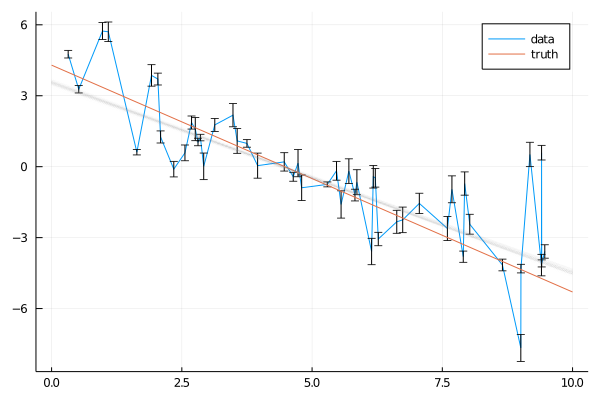

In [157]:
df2 = DataFrame(chain2)
p0 = plot(x, y, yerror=yerr, label="data")
plot!(p0, x0, m_true .* x0 .+ b_true, label="truth")

for val in eachrow(df2[1000:100:end, ["vp[1]", "vp[2]"]])
    val = Array(val)
    plot!(p0, x0, generative(lm, x0; p=val), label="", linealpha=0.01, linecolor=:grey)
end
p0